<a href="https://colab.research.google.com/github/jhyn1687/cat-dog-colab/blob/main/Cats_vs_Dogs_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning on Kaggle Competition: Cats vs Dogs

We're doing some **transfer learning** by fine tuning a similar model with the pretrained weights on a different dataset (https://www.kaggle.com/c/dog-vs-cat-classification/data).

## Downloading Kaggle Competition Data

### Making sure we're on the right API version

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=9a6dc40ab450dd84f569d85b47ee85a39e61cc41481ff5f79634cd01d1d1893e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


### Co-lab API setup


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


### Downloading Data and Unzipping

In [ ]:
!kaggle competitions download -c dog-vs-cat-classification

In [ ]:
!unzip dog-vs-cat-classification.zip -d dog-vs-cat-classification

## Setup 

We're going to modify using transfer learning code from Tutorial 3, 

### Imports

In [ ]:
import torch
import os 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
import tensorflow as tf
from tensorflow import keras
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Training function

We used the training function from the 3rd Pytorch tutorial from class. It has a `schedule` parameter to handle learning rate scheduling and also a `checkpoint_path` parameter which will be where training checkpoints are saved (if provided).

Just like the tutorial from class we "get a batch, run the model forward, calculate loss, run it backward, update".

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
  net.to(device)
  net.train()
  losses = []
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # Load previous training state
  if state:
      net.load_state_dict(state['net'])
      optimizer.load_state_dict(state['optimizer'])
      start_epoch = state['epoch']
      losses = state['losses']

  # Fast forward lr schedule through already trained epochs
  for epoch in range(start_epoch):
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

  for epoch in range(start_epoch, epochs):
    sum_loss = 0.0

    # Update learning rate when scheduled
    if epoch in schedule:
      print ("Learning rate: %f"% schedule[epoch])
      for g in optimizer.param_groups:
        g['lr'] = schedule[epoch]

    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # autograd magic, computes all the partial derivatives
        optimizer.step() # takes a step in gradient direction

        losses.append(loss.item())
        sum_loss += loss.item()
        
        if i % print_every == print_every-1:    # print every 10 mini-batches
            if verbose:
              print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
            sum_loss = 0.0
    if checkpoint_path:
      state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
      torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
  return losses

def accuracy(net, dataloader):
  net.eval()

  result_array, image_paths = np.array([]), np.array([])
 
  with torch.no_grad():
      for i, (image, image_path) in enumerate(dataloader):
          test_input = image.to(device)
          outputs = net(test_input)
          _, predicted = torch.max(outputs, 1)
          result_array = np.append(result_array, predicted.cpu().detach().numpy())
          image_paths = np.append(image_paths, image_path)
  
  return {'results': result_array, 'image_paths': image_paths}

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

## Loading Data into Python

### Custom dataloader for testing samples

We had to use a custom dataloader because .ImageFolder did not work for our testing data.

In [ ]:
class TestingDataset(Dataset):
    
    def __init__(self, root, transforms=None):
        self.transforms = transforms
        self.img_paths = sorted(os.path.join(root, x) for x in os.listdir(root) if x.endswith('.jpg'))

        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        sample = default_loader(img_path)
        if self.transforms is not None:
            sample = self.transforms(sample)
        return sample, img_path.split('/')[-1]

In [ ]:
def get_kaggle_data(augmentation=0):
  # Data augmentation transformations. Not for Testing!
  if augmentation:
    transform_train = transforms.Compose([
      transforms.Resize((256,256)),
      transforms.RandomCrop(224, padding=16, padding_mode='edge'),
      transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  else: 
    transform_train = transforms.ToTensor()

  transform_test = transforms.Compose([                               
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
  ])

  data_dir = '/content/dog-vs-cat-classification'

  trainset = torchvision.datasets.ImageFolder(data_dir + '/train/train', transform=transform_train)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=125, shuffle=True,
                                            num_workers=2)

  testset = TestingDataset(data_dir + '/test/test', transforms=transform_test)
  testloader = torch.utils.data.DataLoader(testset, batch_size=125, shuffle=False,
                                          num_workers=2)
  classes = ['cat', 'dog']
  return {'train': trainloader, 'test': testloader, 'classes': classes}

kaggle_data = get_kaggle_data(augmentation=1)
!ls

dog-vs-cat-classification  dog-vs-cat-classification.zip  sample_data


### Visualize data

This is what our data looks like!

tensor(1) = dog

tensor(0) = cat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])


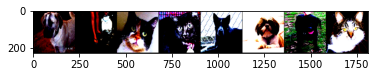

Labels:tensor(1) tensor(1) tensor(0) tensor(0) tensor(1) tensor(1) tensor(1) tensor(0)
torch.Size([8, 3, 224, 224])
torch.Size([8, 150528])


In [ ]:
dataiter = iter(kaggle_data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

## Let's do some DarkNet


In [ ]:
class Darknet64Kaggle(nn.Module):
    def __init__(self):
        super(Darknet64Kaggle, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc10 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        x = self.fc10(x)
        return x

### Darknet running for 15 Epochs

We will run for 15 epochs and decerase the learning rate every 5 epochs.

In [ ]:
darknet = Darknet64Kaggle()
darknet_losses = train(darknet, kaggle_data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)
plt.plot(smooth(darknet_losses,50))

### Darknet running for 30 Epochs

Now lets increase the amount of epochs that we run the DarkNet model for from 15 to 30 and see if there is a difference. 

We will also change the learning rate to decrease every 10 epochs

Learning rate: 0.010000
[0,   100] loss: 0.620
[0,   200] loss: 0.555
[1,   100] loss: 0.514
[1,   200] loss: 0.512
[2,   100] loss: 0.474
[2,   200] loss: 0.475
[3,   100] loss: 0.428
[3,   200] loss: 0.410
[4,   100] loss: 0.403
[4,   200] loss: 0.388
[5,   100] loss: 0.358
[5,   200] loss: 0.350
[6,   100] loss: 0.338
[6,   200] loss: 0.331
[7,   100] loss: 0.310
[7,   200] loss: 0.302
[8,   100] loss: 0.270
[8,   200] loss: 0.260
[9,   100] loss: 0.257
[9,   200] loss: 0.247
Learning rate: 0.001000
[10,   100] loss: 0.205
[10,   200] loss: 0.192
[11,   100] loss: 0.188
[11,   200] loss: 0.187
[12,   100] loss: 0.186
[12,   200] loss: 0.177
[13,   100] loss: 0.181
[13,   200] loss: 0.180
[14,   100] loss: 0.180
[14,   200] loss: 0.176
[15,   100] loss: 0.167
[15,   200] loss: 0.179
[16,   100] loss: 0.175
[16,   200] loss: 0.171
[17,   100] loss: 0.176
[17,   200] loss: 0.170
[18,   100] loss: 0.169
[18,   200] loss: 0.165
[19,   100] loss: 0.166
[19,   200] loss: 0.165
Learning rat

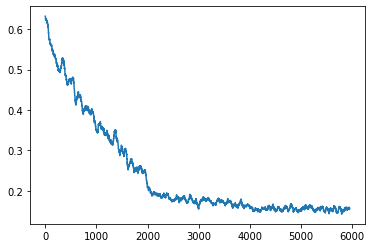

In [ ]:
darknet_30 = Darknet64Kaggle()
darknet_30_losses = train(darknet_30, kaggle_data['train'], epochs=30, schedule={0:.01, 10:.001, 20:.0001}, print_every=100)
plt.plot(smooth(darknet_30_losses,50))

## What about ResNet?
Using pretrained models from PyTorch, we will try 2 different ResNet models to see which one is the best at classifying Cats vs Dogs.




### ResNet18
First, we will load the ResNet18 model that's pretrained from PyTorch.

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[0,   100] loss: 0.078
[0,   200] loss: 0.046
[1,   100] loss: 0.034
[1,   200] loss: 0.028
[2,   100] loss: 0.018
[2,   200] loss: 0.018
[3,   100] loss: 0.014
[3,   200] loss: 0.014
[4,   100] loss: 0.012
[4,   200] loss: 0.011


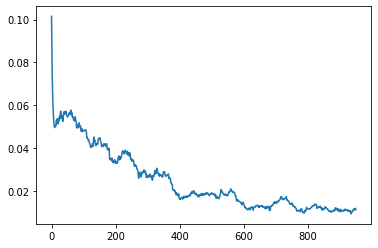

In [ ]:
#Get our kaggle data and load ResNet18 from PyToch 
kaggle_data = get_kaggle_data(augmentation=1)
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 2) # Reinitializes final layer, assigns random weights

#Start training and plot the loss
resnet_losses = train(resnet, kaggle_data['train'], epochs=5, lr=.01, print_every=100)
plt.plot(smooth(resnet_losses,50))

### ResNet18-SWSL

Now we will use another ResNet model to see the difference between the two.

Using cache found in /root/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


[0,   100] loss: 0.087
[0,   200] loss: 0.062
[1,   100] loss: 0.038
[1,   200] loss: 0.040
[2,   100] loss: 0.028
[2,   200] loss: 0.030
[3,   100] loss: 0.028
[3,   200] loss: 0.021
[4,   100] loss: 0.017
[4,   200] loss: 0.021


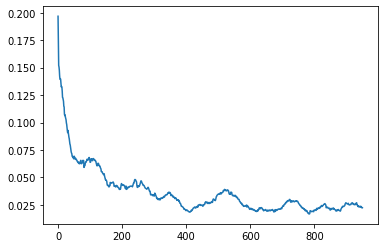

In [ ]:
#Get our Kaggle data and load ResNet18-SWSL from PyTorch
kaggle_data = get_kaggle_data(augmentation=1)
resnet_swsl = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet18_swsl')
resnet_swsl.fc = nn.Linear(512, 2) # Reinitializes final layer, assigns random weights

#Start training and plot the loss
resnet_swsl_losses = train(resnet_swsl, kaggle_data['train'], epochs=5, lr=.01, print_every=100)
plt.plot(smooth(resnet_swsl_losses,50))

## Comparing the Three Models


### Comparing the losses
First lets look at the losses of our models.
*   Red = DarkNet ran with 15 epochs
*   Cyan = DarkNet ran with 30 epochs
*   Green = ResNet18
*   Blue = ResNet18-SWSL

As we can see the ResNet models had the lowest losses while the DarkNet models had the worst. 

The DarkNet model that ran for 30 epochs did a little better than the one that ran for 15 epochs.





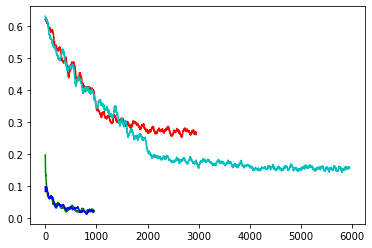

In [ ]:
plt.plot(smooth(darknet_losses,50), 'r-')
plt.plot(smooth(darknet_30_losses,50), 'c-')
plt.plot(smooth(resnet_losses,50),'g-')
plt.plot(smooth(resnet_swsl_losses,50),'b-')

### Comparing Accuracy


First we need to mount a google drive inorder to upload the CSV files. This is so we can compare our models' predictions on the test data to the real labels of the testing dataset on the Kaggle website.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
csv = '/content/drive/MyDrive/colab_files/final_proj/'
if not os.path.exists(csv):
    os.makedirs(csv)

Mounted at /content/drive


Now we can start testing!

First we'll run our accuracy function on each modell so we can get the array with the preditctions that the model made for each image in our testing dataset.

Then we'll export them into a .csv and uploading them into Kaggle to be checked against what the real labels for the testing dataset are.

In [ ]:
#DarkNet (15 epochs)
#Testing and exporting CSV file of the DarkNet mdel that ran for 15 epochs
darknet_results = accuracy(darknet, kaggle_data['test'])
darknet_results['results'] = darknet_results['results'].astype('uint8')
df_darknet = pd.DataFrame({'id': darknet_results['image_paths'], 'labels': darknet_results['results']})
df_darknet.to_csv(csv +'darknet_submission.csv', index=False)

#DarkNet (30 epochs)
#Testing and exporting CSV file
darknet_30_results = accuracy(darknet_30, kaggle_data['test'])
darknet_30_results['results'] = darknet_30_results['results'].astype('uint8')
df_darknet_30 = pd.DataFrame({'id': darknet_30_results['image_paths'], 'labels': darknet_30_results['results']})
df_darknet_30.to_csv(csv +'darknet_30_submission.csv', index=False)

#ResNet18
#Testing and exporting CSV file
resnet_results = accuracy(resnet, kaggle_data['test'])
resnet_results['results'] = resnet_results['results'].astype('uint8')
df_resnet = pd.DataFrame({'id': resnet_results['image_paths'], 'labels': resnet_results['results']})
df_resnet.to_csv(csv + 'resnet_submission.csv', index=False)

#ResNet18-SWSL
#Testing and exporting CSV file
resnet_swsl_results = accuracy(resnet_swsl, kaggle_data['test'])
resnet_swsl_results['results'] = resnet_swsl_results['results'].astype('uint8')
df_resnet_swsl = pd.DataFrame({'id': resnet_swsl_results['image_paths'], 'labels': resnet_swsl_results['results']})
df_resnet_swsl.to_csv(csv + 'resnet_swsl_submission.csv', index=False)

After uploading each of our model's CSV file into the Kaggle website they caculated the accuracy by comparing the model's predictions to the actual labels of the testing dataset. 

As we can see ResNet18 did the best for and the DarkNet model that ran for 15 epochs did the worst.

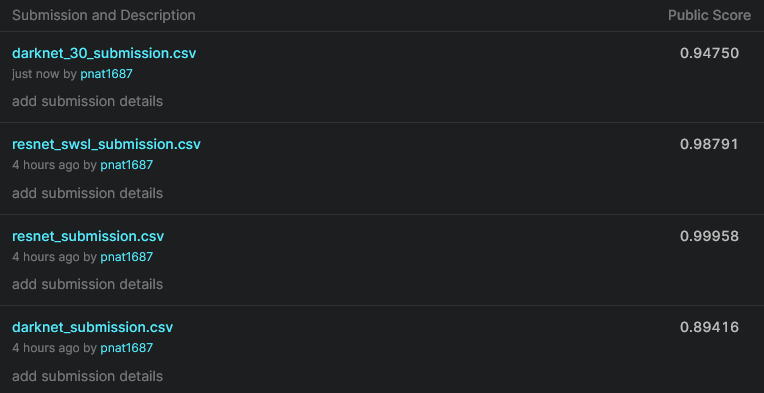